In [165]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import (
    AdaBoostClassifier, 
    GradientBoostingClassifier, 
    RandomForestClassifier, 
    BaggingClassifier, 
    StackingClassifier
)

from warnings import filterwarnings
filterwarnings("ignore")

In [166]:
sns.set_theme()
heart_df = pd.read_csv("heart.csv")
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [167]:
heart_df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Оценка распределений и корреляций

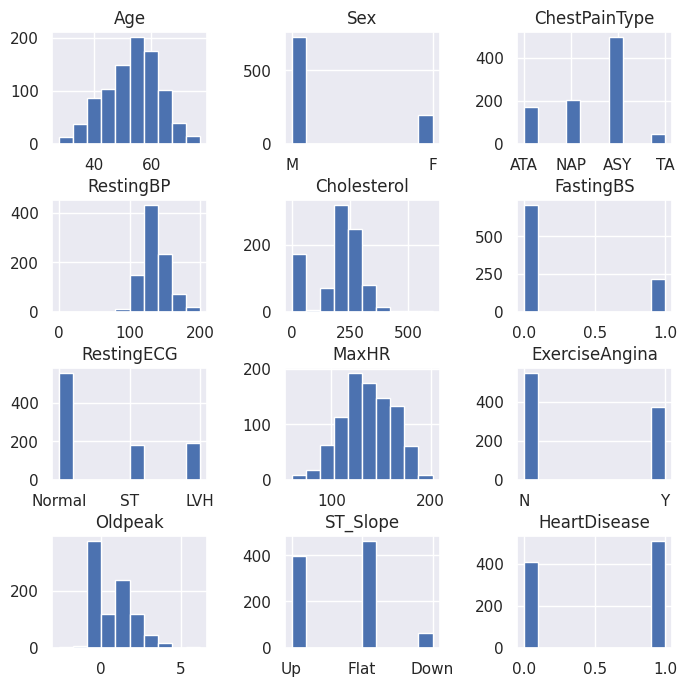

In [168]:
fig, axs = plt.subplots(4, 3, figsize=(8, 8), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
columns = list(heart_df)
for i, ax in enumerate(axs.flat):
    if i < len(columns):
        ax.hist(heart_df[columns[i]], bins=10)
        ax.set_title(columns[i])
plt.show()

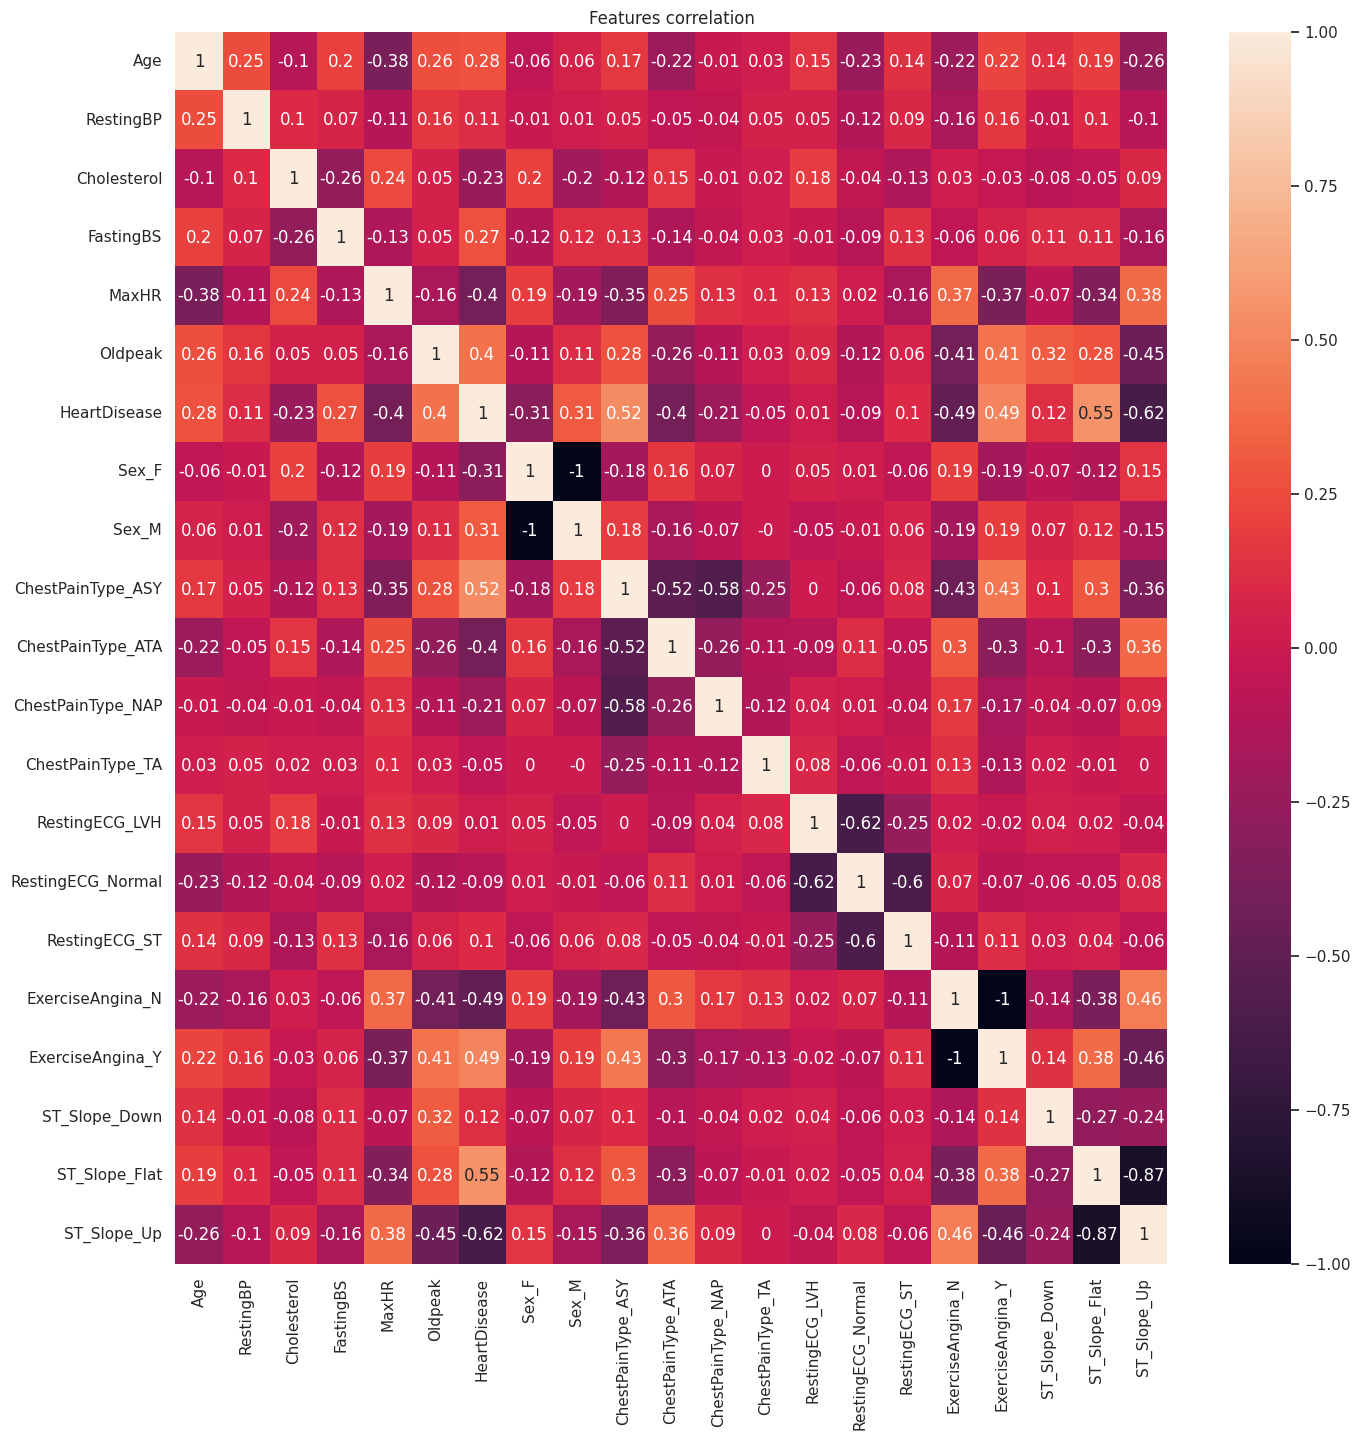

In [169]:
plt.figure(figsize=(16, 16))
sns.heatmap(pd.get_dummies(heart_df).corr().round(2), annot=True).set_title("Features correlation")
plt.show()

### train test

In [61]:
X = pd.get_dummies(heart_df.loc[:, ["Age",	"Sex",	"ChestPainType", "RestingBP", "Cholesterol", "FastingBS", "RestingECG",	"MaxHR", "ExerciseAngina",	"Oldpeak",	"ST_Slope"]])
y = heart_df["HeartDisease"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Подбор лучших параметров

In [119]:
estimator = DecisionTreeClassifier()
params = {
    "max_depth": range(1, 10),
    "min_samples_split": range(30, 50),
    "min_samples_leaf": range(10, 30)
}

In [120]:
gscv = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    cv=5
).fit(X_train, y_train)
gscv.best_params_

{'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 31}

### Сравнение алгоритмов 

In [121]:
tree_clf = DecisionTreeClassifier(max_depth=4, min_samples_split=31, min_samples_leaf=10, random_state=42)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        77
           1       0.88      0.88      0.88       107

    accuracy                           0.86       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.86      0.86      0.86       184



In [191]:
rf_clf = RandomForestClassifier(
    n_estimators=1000, 
    max_depth=4, 
    min_samples_split=31, 
    min_samples_leaf=10, 
    random_state=42,
    max_samples=0.5,
    max_features=4
)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83        77
           1       0.89      0.87      0.88       107

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



### Важность признаков

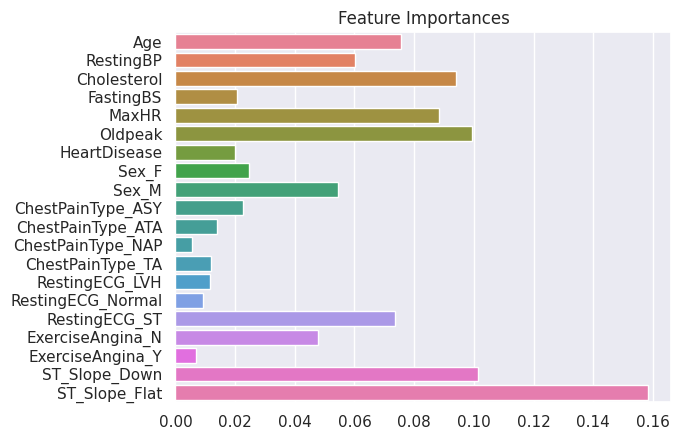

In [89]:
feat = pd.DataFrame(rf_clf.feature_importances_, index=list(pd.get_dummies(heart_df))[:-1])
sns.barplot(feat.T, orient="y").set_title("Feature Importances")
plt.show()

### Бэггинг

In [172]:
tree_bagging = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=1000
)
tree_bagging.fit(X_train, y_train)
y_pred = tree_bagging.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        77
           1       0.91      0.88      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



### Стекинг

In [174]:
estimators = [
        ("tree", DecisionTreeClassifier(random_state=42)),
        ("forest", RandomForestClassifier(random_state=42)),
        ("svc", LinearSVC())
]
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=DecisionTreeClassifier(max_depth=4, min_samples_split=31, min_samples_leaf=10, random_state=42),
)
stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84        77
           1       0.91      0.84      0.87       107

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



# Boost алгоритмы

### AdaBoostClassifier

In [197]:
ada_boost = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=4, min_samples_split=31, min_samples_leaf=10, random_state=42),
    n_estimators=100,
    learning_rate=0.01
)
ada_boost.fit(X_train, y_train)
y_pred = ada_boost.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86        77
           1       0.91      0.90      0.90       107

    accuracy                           0.89       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



### GradientBoostingClassifier

In [179]:
grad_boost = GradientBoostingClassifier(
    learning_rate=0.01,
    n_estimators=1000,
    random_state=42
)
grad_boost.fit(X_train, y_train)
y_pred = grad_boost.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87        77
           1       0.92      0.89      0.90       107

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



In [180]:
lgbm = LGBMClassifier(
    random_state=42
)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

[LightGBM] [Info] Number of positive: 401, number of negative: 333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 372
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546322 -> initscore=0.185819
[LightGBM] [Info] Start training from score 0.185819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [181]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.80      0.86      0.82        77
           1       0.89      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



### CatBoostClassifier

In [182]:
cat = CatBoostClassifier(
    random_state=42
)
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)

Learning rate set to 0.009028
0:	learn: 0.6859286	total: 2.57ms	remaining: 2.57s
1:	learn: 0.6780178	total: 5.51ms	remaining: 2.75s
2:	learn: 0.6700323	total: 7.72ms	remaining: 2.57s
3:	learn: 0.6634365	total: 10ms	remaining: 2.49s
4:	learn: 0.6575008	total: 12.4ms	remaining: 2.48s
5:	learn: 0.6510882	total: 15.1ms	remaining: 2.5s
6:	learn: 0.6442619	total: 18.3ms	remaining: 2.6s
7:	learn: 0.6376825	total: 20.6ms	remaining: 2.55s
8:	learn: 0.6291134	total: 22.9ms	remaining: 2.52s
9:	learn: 0.6224667	total: 25.2ms	remaining: 2.5s
10:	learn: 0.6164760	total: 27.6ms	remaining: 2.48s
11:	learn: 0.6098028	total: 30ms	remaining: 2.47s
12:	learn: 0.6031485	total: 32.4ms	remaining: 2.46s
13:	learn: 0.5992802	total: 33.5ms	remaining: 2.36s
14:	learn: 0.5932220	total: 35.7ms	remaining: 2.34s
15:	learn: 0.5879983	total: 37.4ms	remaining: 2.3s
16:	learn: 0.5830173	total: 39.7ms	remaining: 2.29s
17:	learn: 0.5771547	total: 42.2ms	remaining: 2.3s
18:	learn: 0.5732875	total: 43.4ms	remaining: 2.24s
1

In [183]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88        77
           1       0.92      0.91      0.91       107

    accuracy                           0.90       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.90      0.90      0.90       184



### XGBClassifier

In [184]:
xgboost = XGBClassifier(random_state=42)
xgboost.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        77
           1       0.90      0.88      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184



# Выводы
1. Лучше всего себя показали бустинг модели, дерево с хорошо подобранными гиперпараметрами показало себя почти также, как рандомный лес.
2. В данной задаче CatBoost показал себя лучше всего, из sklearn -  GradientBoosting. Кажется нельзя выделить конкретного фаворита.